# Autoencoders

In [1]:
# Autoreloading makes development easier
%load_ext autoreload
%autoreload 2

In [42]:
# Import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow_probability as tfp
import json
from sklearn.model_selection import train_test_split
from tools.audio_tools import read_audio, write_audio, play_audio
from tools.feature_tools import compute_mels, compute_imels, compute_mfcc, compute_imfcc, load_data, normalize_features, denormalize_features
from tools.constants import cut_classical_path, cut_jazz_path, models_path
from tools.plot_tools import make_figax, plot_history, plot_audio, plot_spectral_feature
from tools.tensorflow_tools import Conv2DEncoder, Conv2DDecoder

## Data Loading

### Load Audio & Extract Features

In [3]:
# Which style to load
style = "classical"

# Load Style
if style == "classical":
    X_raw = load_data(cut_classical_path)
else:
    X_raw = load_data(cut_jazz_path)

# Print feature shape
print(f"{X_raw.shape = }")

100 %
X_raw.shape = (601, 67, 128, 1)


### Train - Validation - Test Split

In [4]:
# Fraction of data to keep apart for validation
test_fraction = 0.1
# Perform split
X_raw_train, X_raw_test = train_test_split(X_raw, test_size=test_fraction)
# Verify split shapes
print(f"{X_raw_train.shape = }")
print(f"{X_raw_test.shape = }")

X_raw_train.shape = (540, 67, 128, 1)
X_raw_test.shape = (61, 67, 128, 1)


In [5]:
input_shape = X_raw_train.shape[1:]
print(f"{input_shape = }")

input_shape = (67, 128, 1)


### Normalize Features

In [6]:
# Perform normalization
X_train, X_test = normalize_features(X_raw_train, X_raw_test)

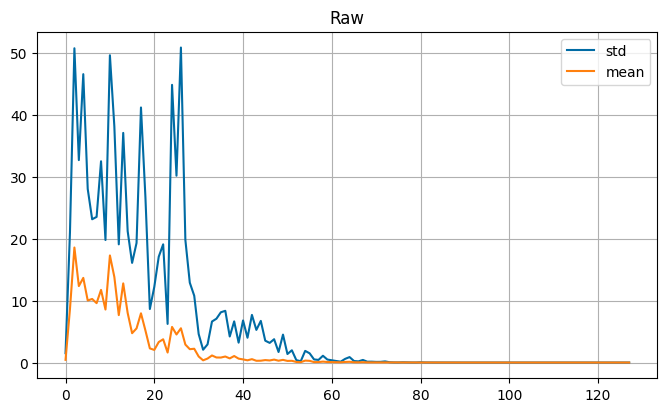

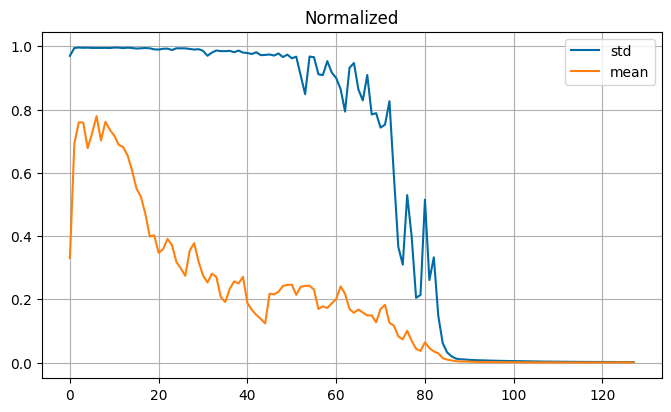

In [7]:
# See the effect of normalization
fig, ax = make_figax()
ax.plot(np.std(X_raw_train, axis=(0,1,3)), label="std")
ax.plot(np.mean(X_raw_train, axis=(0,1,3)), label="mean")
#ax.plot(np.max(X_raw_train, axis=(0,1,3)), label="max")
ax.grid()
ax.legend()
ax.set_title("Raw")
plt.show()


fig, ax = make_figax()
ax.plot(np.std(X_train, axis=(0,1,3)), label="std")
ax.plot(np.mean(X_train, axis=(0,1,3)), label="mean")
#ax.plot(np.max(X_train, axis=(0,1,3)), label="max")
ax.grid()
ax.legend()
ax.set_title("Normalized")
plt.show()

## Autoencoders

### Test Script

In [39]:
nop = lambda x: x

def test_autoencoder(autoencoder, test_set = X_test, plot_transforms = True, plot_raw_transforms = True, plot_waveforms = True):
  # Pick sample at random
  print("Picking Sample")
  choice = np.random.choice(len(test_set))
  x = test_set[choice]

  # Autencoder
  print("Autencoding")
  x_hat = np.array(autoencoder(x.reshape((1, *x.shape))))

  if plot_transforms:
    print("Plotting transforms")
    fig, ax = plot_spectral_feature(x, fn=nop)
    ax.set_title("Original Preprocessed Spectrum")
    fig, ax = plot_spectral_feature(x_hat, fn=nop)
    ax.set_title("Reconstructed Preprocessed Spectrum")
    plt.show()

  # Postprocess
  print("Postprocessing")
  x_raw = denormalize_features(x.reshape((1, *x.shape)))[0]
  x_raw_hat = denormalize_features(x_hat.reshape((1, *x.shape)))[0]

  if plot_raw_transforms:
    print("Plotting transforms")
    fig, ax = plot_spectral_feature(x_raw)
    ax.set_title("Original Raw Spectrum")
    fig, ax = plot_spectral_feature(x_raw_hat)
    ax.set_title("Reconstructed Raw Spectrum")
    plt.show()

  # Reconstruct Audio
  print("Reconstructing Audio")
  s = np.squeeze(compute_imels(x_raw))
  s_hat = np.squeeze(compute_imels(x_raw_hat))

  if plot_waveforms:
    fig, ax = plot_audio(s)
    ax.set_title("Original Waveform")
    fig, ax = plot_audio(s_hat)
    ax.set_title("Reconstructed Waveform")
    plt.show()

  # Play audio
  print("Original Audio")
  player = play_audio(s)
  print("Reconstructed Audio")
  player = play_audio(s_hat)
  print()

In [9]:
def free_memory(autoencoder):
  krs.backend.clear_session()
  del autoencoder.encoder
  del autoencoder.decoder
  del autoencoder
  krs.backend.clear_session()

In [10]:
os.makedirs(models_path, exist_ok = True)
def save_autoencoder(autoencoder, params, history, name):
    # Define and make directory
    autoencoder_path = os.path.join(models_path, name)
    os.makedirs(autoencoder_path, exist_ok = True)
    
    # Save parameters
    with open(os.path.join(autoencoder_path, "params.json"), "w") as params_file:
        json.dump(params, params_file)
        
    # Save history
    with open(os.path.join(autoencoder_path, "history.json"), "w") as history_file:
        if not isinstance(history, dict):
            history = history.history
        json.dump(history, history_file)
    
    # Save model
    autoencoder.save(os.path.join(autoencoder_path, "model.keras"))

def load_autoencoder(name, load_model = True):
    # Define path
    autoencoder_path = os.path.join(models_path, name)
    
    # Load parameters
    with open(os.path.join(autoencoder_path, "params.json"), "r") as params_file:
        params = json.load(params_file)
    
    # Load history
    with open(os.path.join(autoencoder_path, "history.json"), "r") as history_file:
        history = json.load(history_file)
    
    # Load model
    autoencoder = None
    if load_model:
        autoencoder = krs.models.load_model(os.path.join(autoencoder_path, "model.keras"))
    
    return autoencoder, params, history

### Convolutional Autoencoder

In [11]:
@krs.saving.register_keras_serializable()
class Conv2DAutoencoder(krs.models.Model):
    def __init__(
        self,
        feature_shape,
        compression,
        kernel_size, 
        conv_depth,
        input_chans_multiplier = 1,
        skip_connection=True, 
        activation="relu", 
        pooling_type="average",
    ):
        super().__init__()

        # Save parameters to class
        self.feature_shape = feature_shape
        self.compression = compression
        self.input_time, self.input_mels, self.input_chans = feature_shape
        self.kernel_size = kernel_size
        self.conv_depth = conv_depth
        self.input_chans_multiplier = input_chans_multiplier
        self.skip_connection = skip_connection
        self.activation = activation
        self.pooling_type = pooling_type

        # Determine nr of layers to be used (and check config validity)
        self.k = np.log2(self.input_chans_multiplier)
        assert np.round(self.k) == self.k, "input_chans_multiplier should be a power of 2"
        self.l = np.log2(self.compression)
        assert np.round(self.l) == self.l, "compression should be a power of 2"
        assert self.input_mels / (self.compression * self.input_chans_multiplier) >= 1, "input_chans_multiplier * compression should be smaller than input mels dimension"
        assert self.input_time / (self.compression * self.input_chans_multiplier) >= 1, "input_chans_multiplier * compression should be smaller than input time dimension"
        self.n_layers = int(np.round(self.k + self.l))

        # Determine nr of channels & padding for the encoder layers
        layer_filters = [self.input_chans] + [self.input_chans * self.input_chans_multiplier * 2**(n + 1) for n in range(self.n_layers)]
        layer_padding, time = [None] * self.n_layers, self.input_time
        for n in range(self.n_layers):
            layer_padding[n] = time % 2 == 1
            time = (time + layer_padding[n]) // 2

        # Build encoder
        self.encoder = Conv2DEncoder(
            layer_filters[1:],
            layer_padding,
            self.kernel_size,
            self.conv_depth,
            skip_connection=self.skip_connection,
            activation=self.activation,
            pooling_type=self.pooling_type,
        )

        # Determine nr of channels for the decoder layers
        self.decoder = Conv2DDecoder(
            layer_filters[::-1][1:],
            layer_padding[::-1],
            self.kernel_size,
            self.conv_depth,
            skip_connection=self.skip_connection,
            activation=self.activation,
        )
    
    def call(self, x):
        h = self.encoder(x)
        x_hat = self.decoder(h)
        return x_hat

In [12]:
compression = 8
kernel_size = 3
conv_depth = 1
input_chans_multiplier = 1
skip_connection = False
pooling_type = "average"

autoencoder = Conv2DAutoencoder(
    input_shape,
    compression,
    kernel_size,
    conv_depth,
    input_chans_multiplier=input_chans_multiplier,
    skip_connection=skip_connection,
    pooling_type=pooling_type,
)

In [13]:
autoencoder.compile(optimizer="adam", loss=krs.losses.MeanAbsoluteError())

In [14]:
history = autoencoder.fit(X_train, X_train, epochs=1, shuffle=True, validation_data=(X_test, X_test), verbose=1)

17/17 [==============================] - 3s 63ms/step - loss: 0.1972 - val_loss: 0.2012


In [17]:
autoencoder.encoder.encoder.summary()
autoencoder.decoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_encoder_block (Conv  (None, 34, 64, 2)         20        
 2DEncoderBlock)                                                 
                                                                 
 conv2d_encoder_block_1 (Co  (None, 17, 32, 4)         76        
 nv2DEncoderBlock)                                               
                                                                 
 conv2d_encoder_block_2 (Co  (None, 9, 16, 8)          296       
 nv2DEncoderBlock)                                               
                                                                 
 conv2d_encoder_block_3 (Co  (None, 9, 16, 8)          584       
 nv2DEncoderBlock)                                               
                                                                 
Total params: 976 (3.81 KB)
Trainable params: 976 (3.81 

In [20]:
# Test saving
save_autoencoder(autoencoder, {}, history, "test")
model, params, history = load_autoencoder("test")

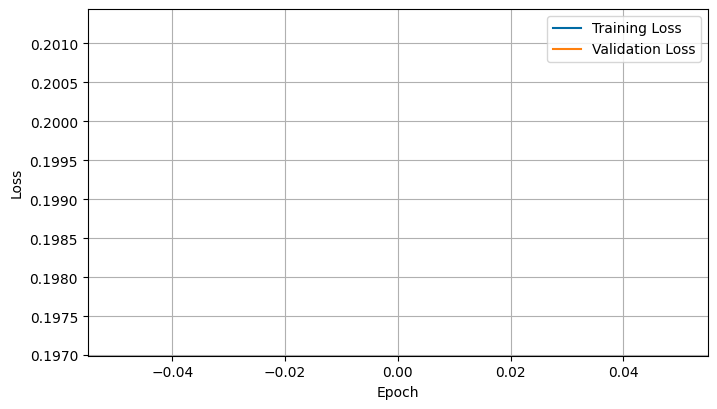

In [25]:
fig, ax = plot_history(history)

Picking Sample
Autencoding
Plotting transforms


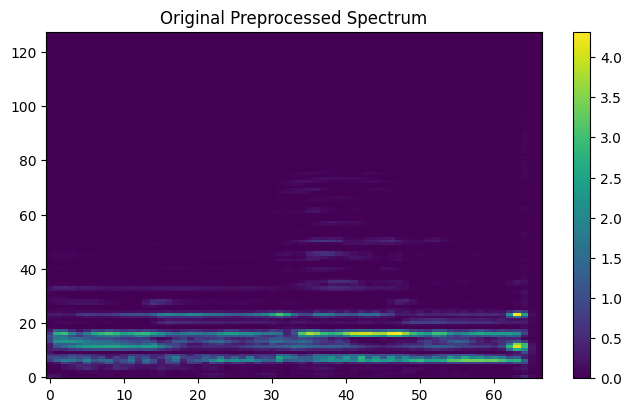

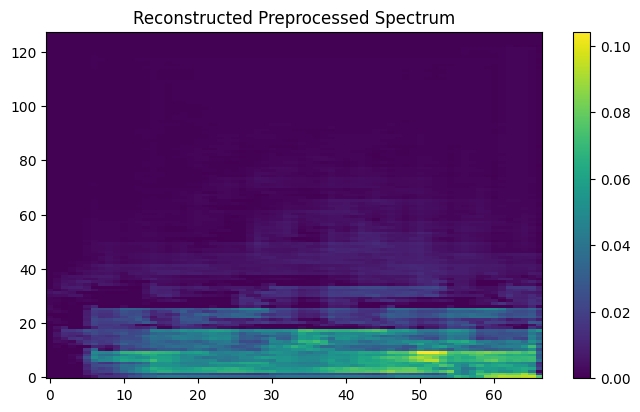

Postprocessing
Plotting transforms


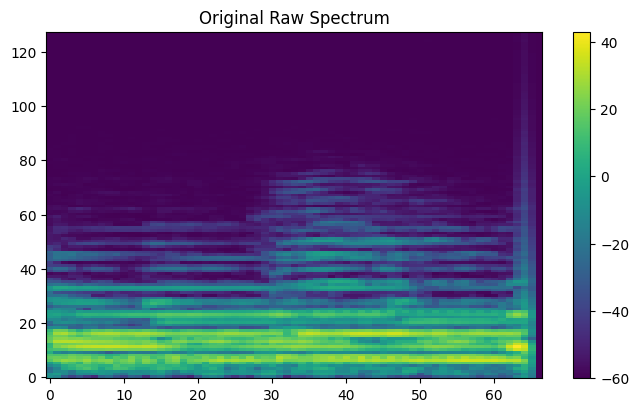

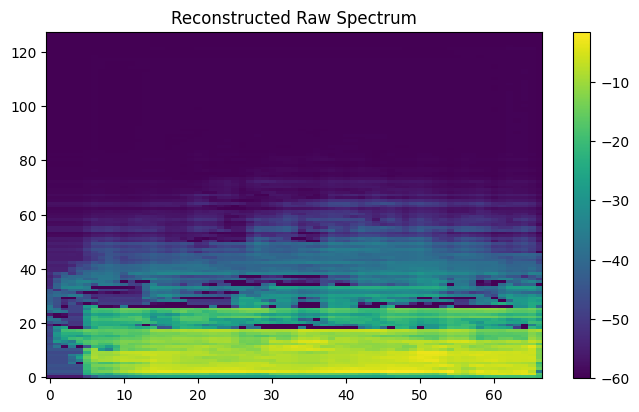

Reconstructing Audio


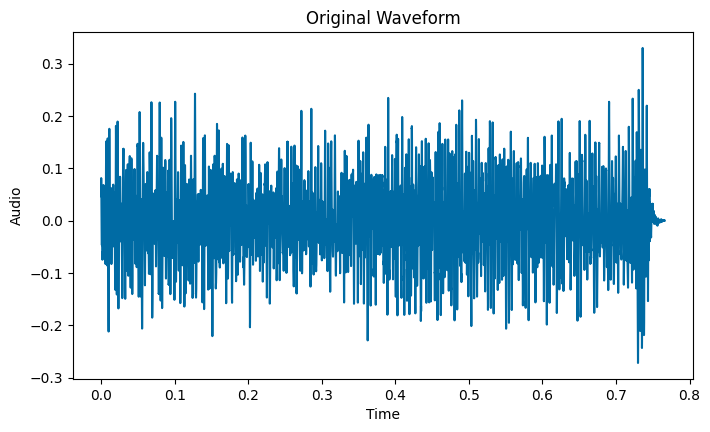

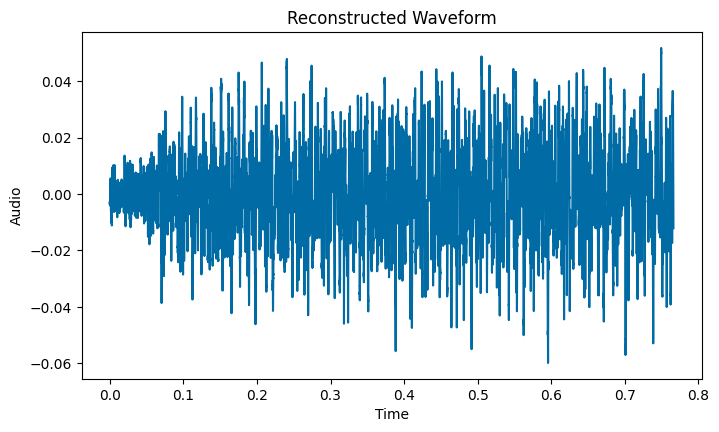

Original Audio


Reconstructed Audio


In [40]:
test_autoencoder(autoencoder)

### Variational Autencoder

In [57]:
class VariationalAutoencoder(krs.models.Model):
    # Based on: https://keras.io/examples/generative/vae/

    def __init__(
        self,
        feature_shape,
        compression,
        kernel_size, 
        conv_depth,
        input_chans_multiplier = 1,
        skip_connection=True, 
        activation="relu", 
        pooling_type="average",
        kl_reg = 1e-3,
    ):
        super().__init__()

        # Save parameters to class
        self.feature_shape = feature_shape
        self.compression = compression
        self.input_time, self.input_mels, self.input_chans = feature_shape
        self.kernel_size = kernel_size
        self.conv_depth = conv_depth
        self.input_chans_multiplier = input_chans_multiplier
        self.skip_connection = skip_connection
        self.activation = activation
        self.pooling_type = pooling_type
        self.kl_reg = kl_reg

        # Determine nr of layers to be used (and check config validity)
        self.k = np.log2(self.input_chans_multiplier)
        assert np.round(self.k) == self.k, "input_chans_multiplier should be a power of 2"
        self.l = np.log2(self.compression)
        assert np.round(self.l) == self.l, "compression should be a power of 2"
        assert self.input_mels / (self.compression * self.input_chans_multiplier) >= 1, "input_chans_multiplier * compression should be smaller than input mels dimension"
        assert self.input_time / (self.compression * self.input_chans_multiplier) >= 1, "input_chans_multiplier * compression should be smaller than input time dimension"
        self.n_layers = int(np.round(self.k + self.l))

        # Determine nr of channels & padding for the encoder layers
        layer_filters = [self.input_chans] + [self.input_chans * self.input_chans_multiplier * 2**(n + 1) for n in range(self.n_layers)]
        layer_padding, time = [None] * self.n_layers, self.input_time
        for n in range(self.n_layers):
            layer_padding[n] = time % 2 == 1
            time = (time + layer_padding[n]) // 2

        # Build encoders
        self.mu_encoder = Conv2DEncoder(
            layer_filters[1:],
            layer_padding,
            self.kernel_size,
            self.conv_depth,
            skip_connection=self.skip_connection,
            activation=self.activation,
            pooling_type=self.pooling_type,
        )

        self.sigma2_encoder = Conv2DEncoder(
            layer_filters[1:],
            layer_padding,
            self.kernel_size,
            self.conv_depth,
            skip_connection=self.skip_connection,
            activation=self.activation,
            pooling_type=self.pooling_type
        )

        # Determine nr of channels for the decoder layers
        self.decoder = Conv2DDecoder(
            layer_filters[::-1][1:],
            layer_padding[::-1],
            self.kernel_size,
            self.conv_depth,
            skip_connection=self.skip_connection,
            activation=self.activation,
        )

        # Keep track of losses
        self.loss_tracker = krs.metrics.Mean(name="loss") # total loss
        self.r_loss_tracker = krs.metrics.Mean(name="r_loss") # reconstruction loss
        self.kl_loss_tracker = krs.metrics.Mean(name="kl_loss") # kullback leibler loss
    
    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.r_loss_tracker,
            self.kl_loss_tracker,
        ]

    def encode(self, x):
        mu = self.mu_encoder(x)
        logsigma2 = self.sigma2_encoder(x)
        return mu, logsigma2
    
    def reparametrize(self, mu, logsigma2):
        z = tf.random.normal(shape=logsigma2.shape[1:])
        h = mu + tf.exp(logsigma2) * z
        return h
    
    def decode(self, h):
        x_hat = self.decoder(h)
        return x_hat

    def call(self, x):
        mu, logsigma2 = self.encode(x)
        h = self.reparametrize(my, logsigma2)
        x_hat = self.decode(h)
        return x_hat
    
    def compute_r_loss(self, x, x_hat):
        r_loss = tf.reduce_mean(tf.abs(x - x_hat)) # MeanAbsoluteError
        self.r_loss_tracker.update_state(r_loss)
        return r_loss

    def compute_kl_loss(self, mu, logsigma2):
        # See: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
        kl_loss = tf.reduce_mean(1/2 * (tf.exp(logsigma2) + mu**2 - logsigma2 - 1))
        self.kl_loss_tracker.update_state(kl_loss)
        return kl_loss

    def compute_loss(self, x, x_hat, mu, logsigma2):
        r_loss = self.compute_r_loss(x, x_hat)
        kl_loss = self.compute_kl_loss(x, x_hat)
        loss = r_loss + self.kl_reg * kl_loss
        self.loss_tracker.update_state(loss)
        return loss
    
    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward propagation
        with tf.GradientTape() as tape:
            # Autoencode
            mu, logsigma2 = self.encode(x)
            h = self.reparametrize(mu, logsigma2)
            x_hat = self.decode(h)

            # Compute loss factors
            loss = self.compute_loss(x, x_hat, mu, logsigma2)
        
        # Backpropagation
        trainable_weights = self.trainable_weights
        gradients = tape.gradient(loss, self.trainable_weights)

        # Optimization step
        self.optimizer.apply_gradients(zip(gradients, trainable_weights))

        # Return loss
        return {
            "loss": self.loss_tracker.result(),
            "r_loss": self.r_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        # Unpack data
        x, y = data

        # Autoencode
        mu, logsigma2 = self.encode(x)
        h = self.reparametrize(mu, logsigma2)
        x_hat = self.decode(h)

        # Commute loss factors
        loss = self.compute_loss(x, x_hat, mu, logsigma2)

        # Return losses
        return {
            "loss": self.loss_tracker.result(),
            "r_loss": self.r_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [61]:
compression = 8
kernel_size = 3
conv_depth = 1
input_chans_multiplier = 1
skip_connection = False
pooling_type = "average"
kl_reg = 1.

autoencoder = VariationalAutoencoder(
    input_shape,
    compression,
    kernel_size,
    conv_depth,
    input_chans_multiplier=input_chans_multiplier,
    skip_connection=skip_connection,
    pooling_type=pooling_type,
    kl_reg=kl_reg
)

In [62]:
autoencoder.compile(optimizer="adam", loss=krs.losses.MeanAbsoluteError())

In [63]:
history = autoencoder.fit(X_train, X_train, epochs=1, shuffle=True, validation_data=(X_test, X_test), verbose=1)

17/17 [==============================] - 4s 78ms/step - loss: 1.1486 - r_loss: 0.5718 - kl_loss: 0.5769 - val_loss: 0.9437 - val_r_loss: 0.4530 - val_kl_loss: 0.4907


### GAN Autoencoder